## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'spaceNet-full' 
TRANSFORM = 'wavelet-diagonal'
CHANNEL = 'gray'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
gray_diagonal_wavelet_full_spaceNet.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/spaceNet/full/wavelet/diagonal/gray'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 13604,
 3: 54416,
 4: 166649,
 5: 574769,
 6: 2125625,
 7: 8502500,
 8: 34010000,
 9: 136040000}

Running 12760 CDFs


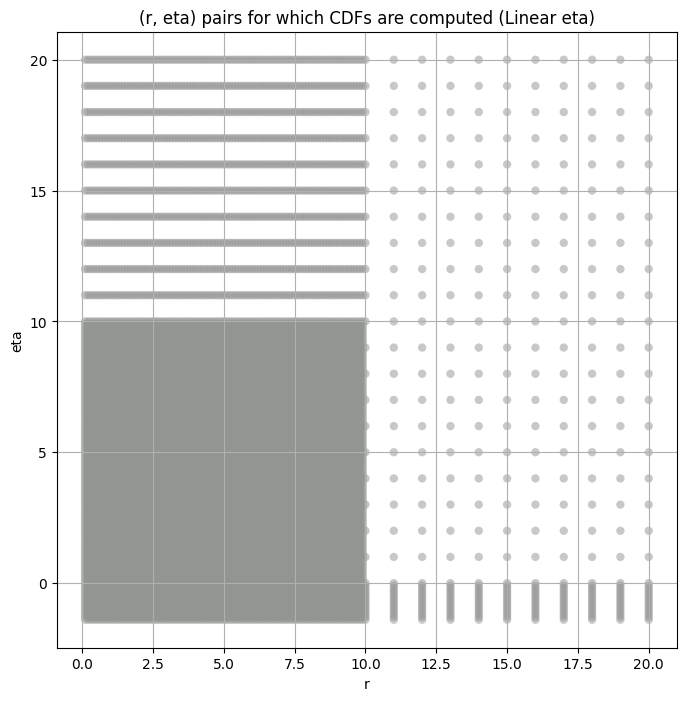

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var    var_lower     var_upper    obs_kurt  kurt_lower  \
layer                                                                   
2      9329.193000  8680.039000  10021.551000    5.728336    3.854069   
3      1371.856000  1239.007400   1522.100800   14.135717    9.524071   
4       585.124450   532.130500    642.267700   11.181561    8.105103   
5       160.717680   146.666210    175.814360   10.452751    7.672978   
6        38.403484    34.960827     42.293262   11.680919    7.695513   
7         8.761599     7.796952      9.977344   20.842588   11.143603   
8         1.901044     1.622445      2.434048   60.534340   15.293455   
9         0.338892     0.277782      0.548111  236.055190   12.296153   

       kurt_upper  total_samples  
layer                             
2        8.267125        13604.0  
3       23.448200        54416.0  
4       16.543982       166649.0  
5       15.774425       574769.0  
6       23.166769      2125625.0  
7       58.113117      8502500.0  
8      272.068180     34010000.0  
9      879.158600    136040000.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                               
2      9329.193000    9329.193359     8300.256836     7760.761719   
3      1371.856000    1371.855957     1274.827637     1221.926392   
4       585.124450     585.124451      562.140930      547.926636   
5       160.717680     160.717682      154.661194      150.888718   
6        38.403484      38.403484       36.766361       35.818291   
7         8.761599       8.761599        8.231873        7.955531   
8         1.901044       1.901044        1.714622        1.639130   
9         0.338892       0.338892        0.290610        0.278702   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2         7348.273926      7013.111328      6469.595703      6039.029297   
3         1179.373169      1143.261475      1081.734985      1031.225830   
4          536.116516       525.783142       508.044464       492.779907   
5          147.797302       145.083923       140.332504       136.232269   
6           35.052044        34.389439        33.255577        32.287369   
7            7.736219         7.549894         7.236329         6.974691   
8            1.582068         1.534972         1.458310         1.396172   
9            0.269969         0.262843         0.251341         0.242072   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2          5681.362793      5362.443359      5079.884277      4380.686523  
3           987.534241       948.385559       913.021790       823.074890  
4           479.126862       466.823700       455.672180       426.610260  
5           132.606339       129.320801       126.313362       118.490776  
6            31.434849        30.667294        29.963032        28.130239  
7             6.747492         6.545689         6.363176         5.899277  
8             1.343368         1.297218         1.256108         1.153709  
9             0.234200         0.227312         0.221161         0.205760

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.010589276548112536 9329.193


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.011211207447160532 8300.257


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.014489025028083136 7760.7617


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.014919407482124614 7348.274


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.015207258911845822 7013.1113


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.017252582858225063 6469.5957


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.020411921950559242 6039.0293


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.024579229180094364 5681.363


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.02855095500732152 5362.4434


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.032442519135091774 5079.8843


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.042936727767840584 4380.6865
Number of samples: 13604, Without approximation : 13604.0


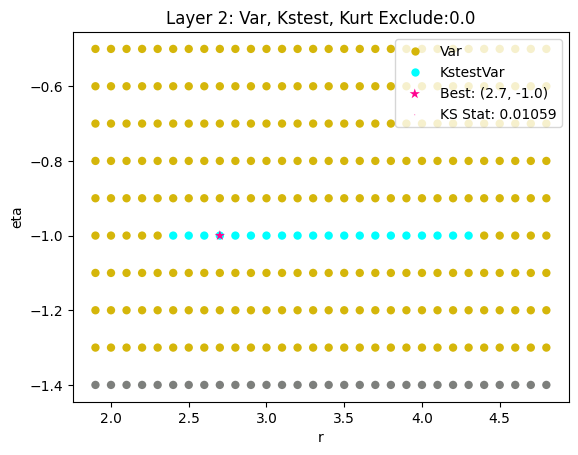

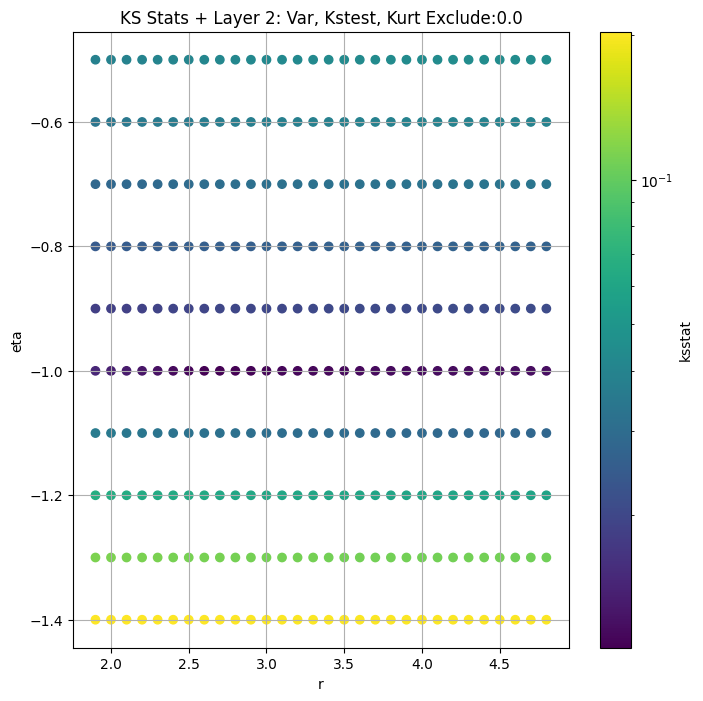

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.22135033813584215 1371.856


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.22135033813584215 1274.8276


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.22135033813584215 1221.9264


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.22135033813584215 1179.3732


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.22135033813584215 1143.2615


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.22135033813584215 1081.735


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.22135033813584215 1031.2258


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.22135033813584215 987.53424


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.22135033813584215 948.38556


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.22135033813584215 913.0218


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.22135033813584215 823.0749
Number of samples: 54416, Without approximation : 54416.0


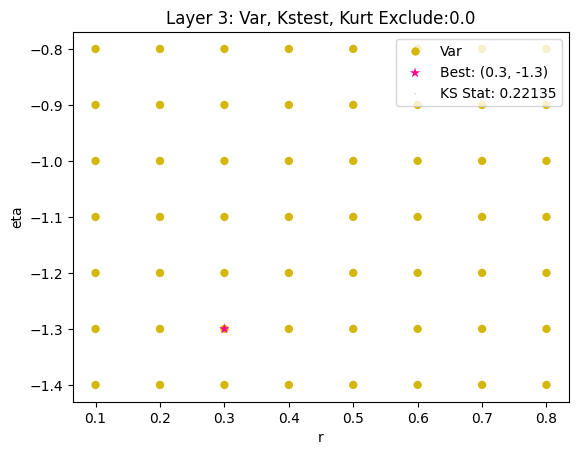

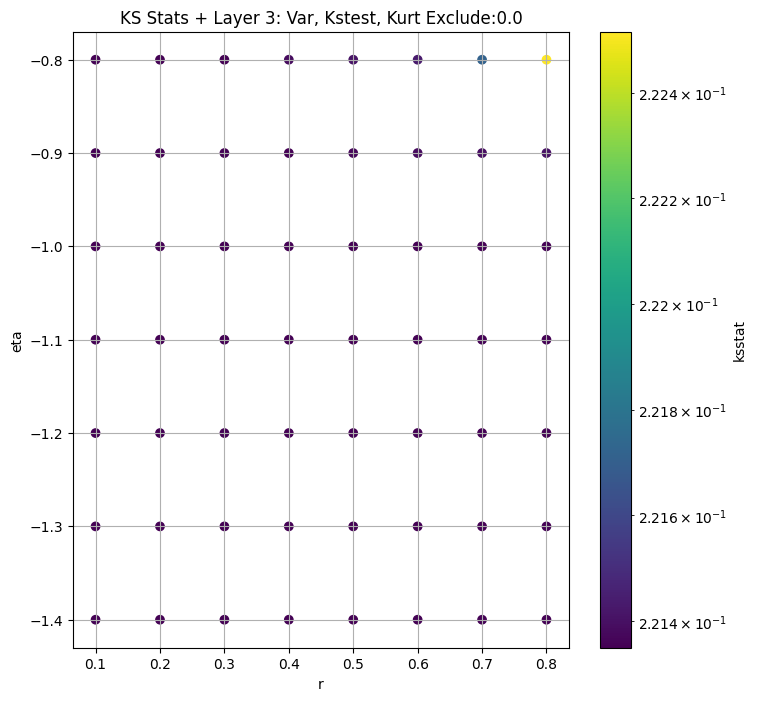

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.1331699999999998 585.12445


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.1331699999999998 562.1409


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.1331699999999998 547.92664


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.1331699999999998 536.1165


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.1331699999999998 525.78314


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.1331699999999998 508.04446


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.1331699999999998 492.7799


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.1331699999999998 479.12686


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.1331699999999998 466.8237


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.1331699999999998 455.67218


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.1331699999999998 426.61026
Number of samples: 100000, Without approximation : 166649.0


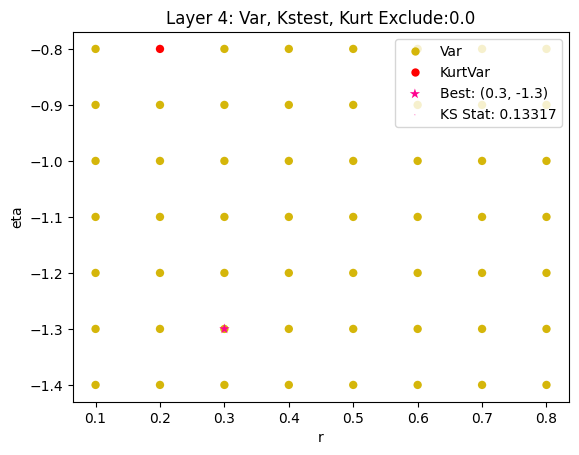

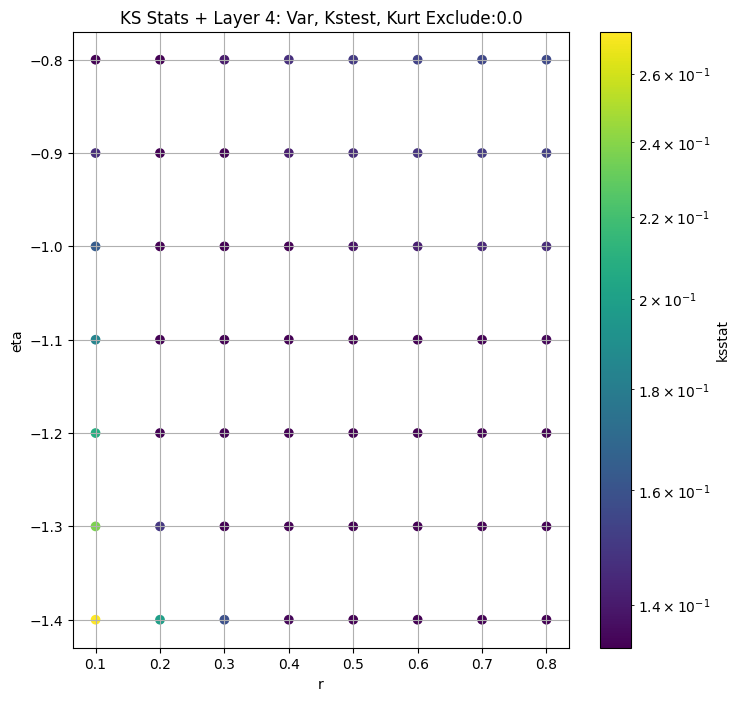

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.07426999999999984 160.71768


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.07426999999999984 154.6612


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.07426999999999984 150.88872


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.07426999999999984 147.7973


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.07426999999999984 145.08392


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.07426999999999984 140.3325


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.07426999999999984 136.23227


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.07426999999999984 132.60634


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.07426999999999984 129.3208


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.07426999999999984 126.31336


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.07426999999999984 118.490776
Number of samples: 100000, Without approximation : 574769.0


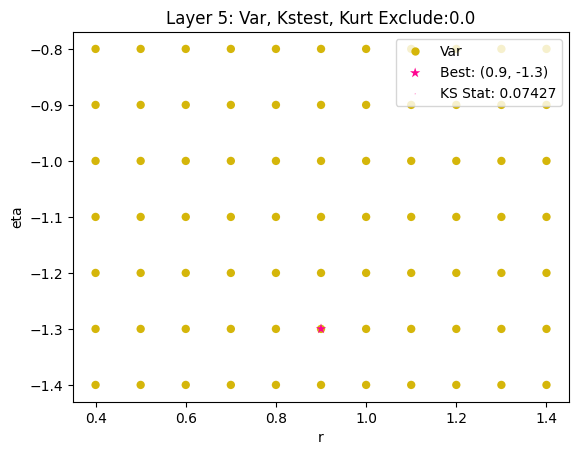

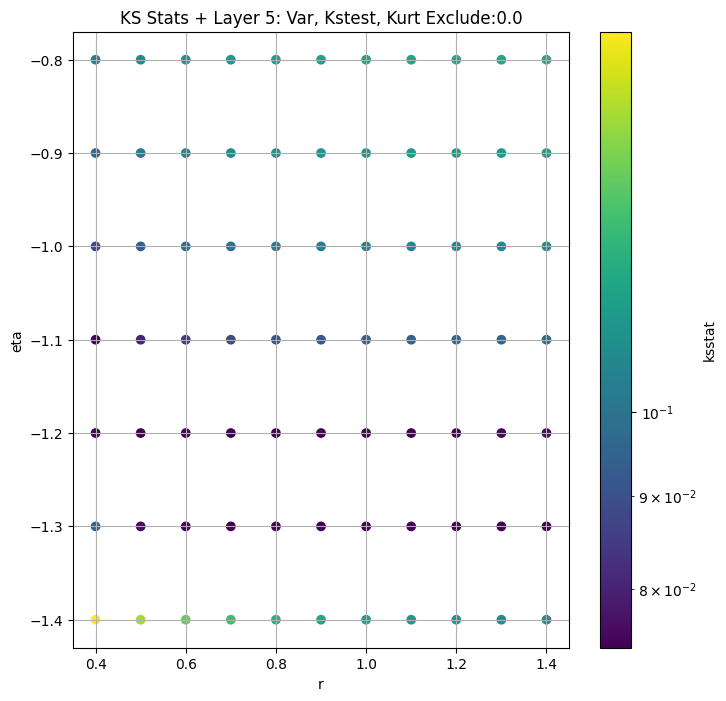

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.009690105457269005 38.403484


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.00950486994739319 36.76636


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.009366823432806481 35.81829


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.009578162224866626 35.052044


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.009439263539714582 34.38944


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.00950909896076646 33.255577


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.009542673071845309 32.28737


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.009539147738919063 31.434849


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.009501066255001134 30.667294


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.009584377826832524 29.963032


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.009722790391267777 28.13024
Number of samples: 100000, Without approximation : 2125625.0


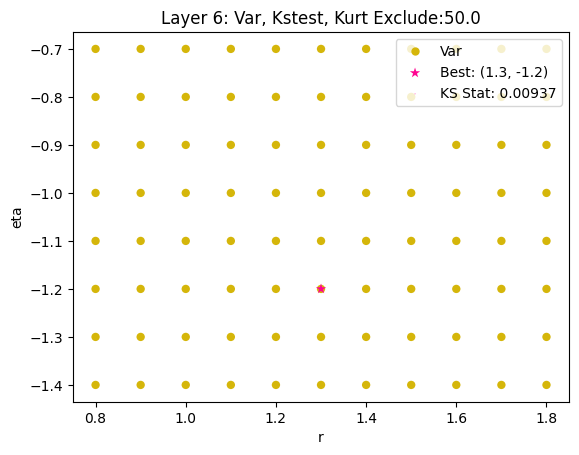

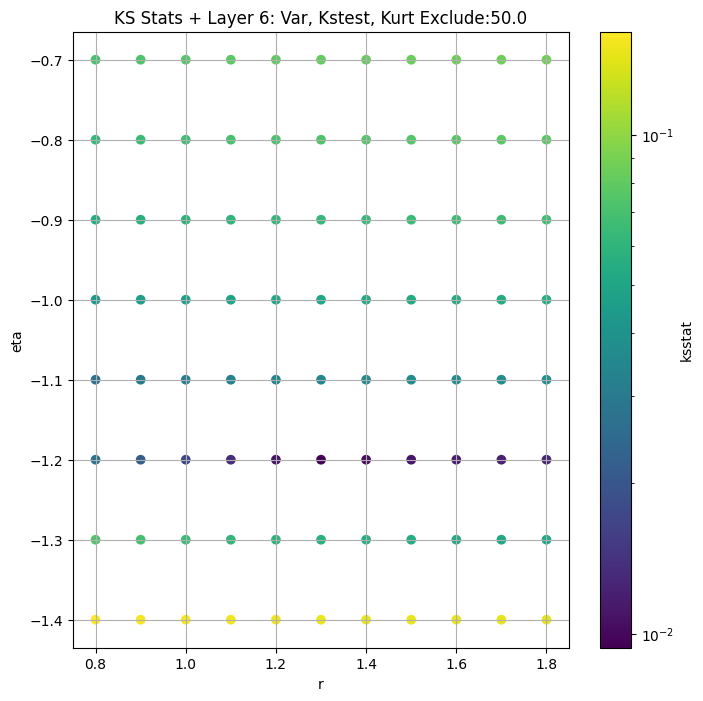

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.008710572469237232 8.761599


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.009411542524405792 8.231873


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.010400531411096758 7.955531


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.012058245750306451 7.736219


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.01350145580490536 7.5498943


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.012044158416016748 7.236329


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.010657632861142075 6.9746914


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.010271603917041516 6.7474923


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.011998273922109282 6.545689


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.01361129033224151 6.363176


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.012493977993501382 5.8992767
Number of samples: 100000, Without approximation : 8502500.0


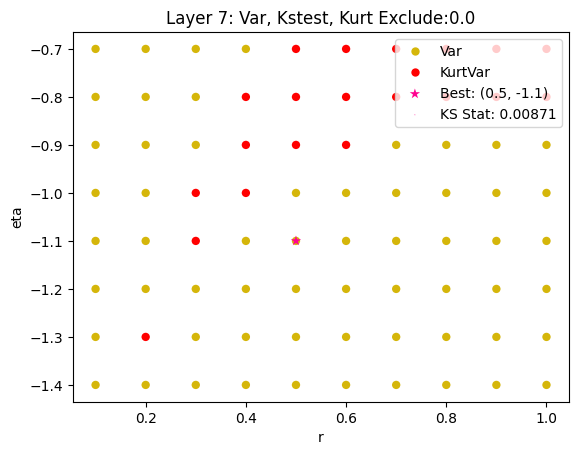

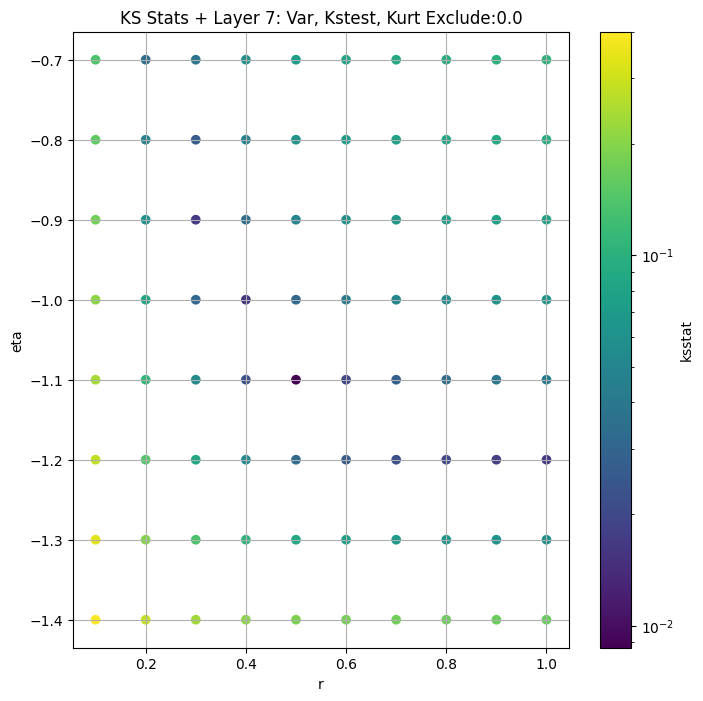

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.0067610303402818595 1.9010442


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.009741194379733864 1.714622


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.009059960358935248 1.6391302


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.006992609956466778 1.5820682


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.008459425013123245 1.5349723


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.010358009044430183 1.4583097


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.010544865355313071 1.3961716


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.011233914899538233 1.343368


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.009655896144214027 1.2972184


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.010054412964646042 1.2561077


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.01117572005978884 1.1537094
Number of samples: 100000, Without approximation : 34010000.0


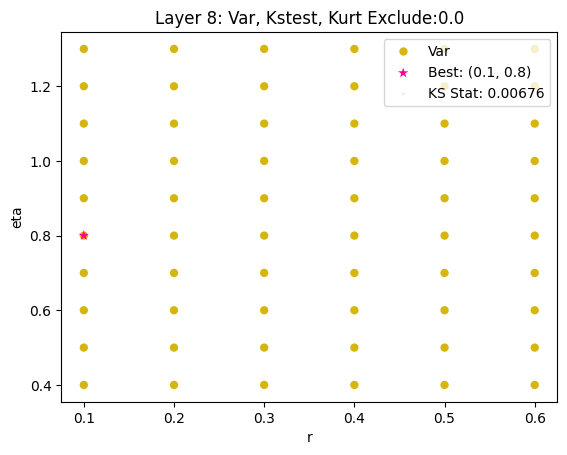

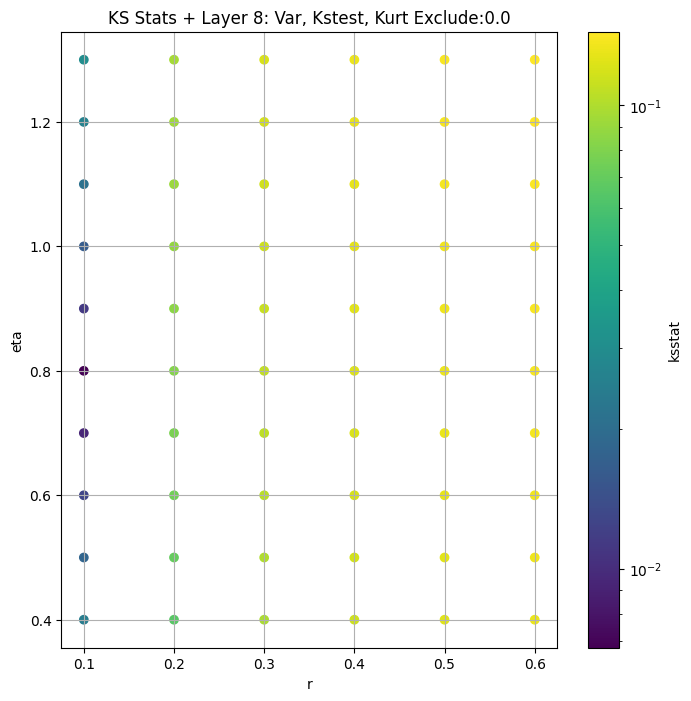

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.009560960137442676 0.33889166


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.009077680089555895 0.29061043


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.009336107496132284 0.2787019


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.009053798971537574 0.2699694


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.009170725866454177 0.26284298


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.009539158400333925 0.25134137


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.009219992148911615 0.24207193


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.008879746666895005 0.2342004


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.00942536782486647 0.22731212


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.009712216253159933 0.22116084


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.009032112728290458 0.20576014
Number of samples: 100000, Without approximation : 136040000.0


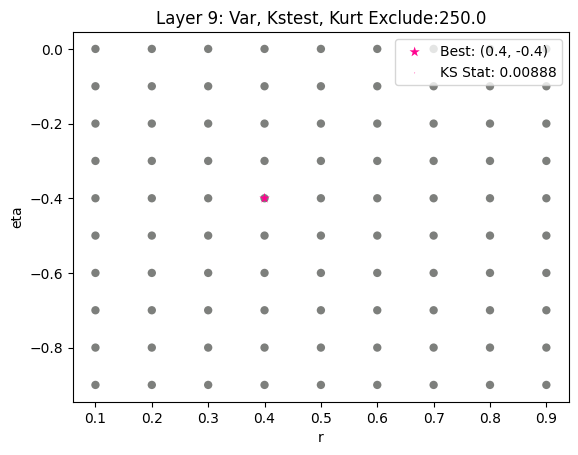

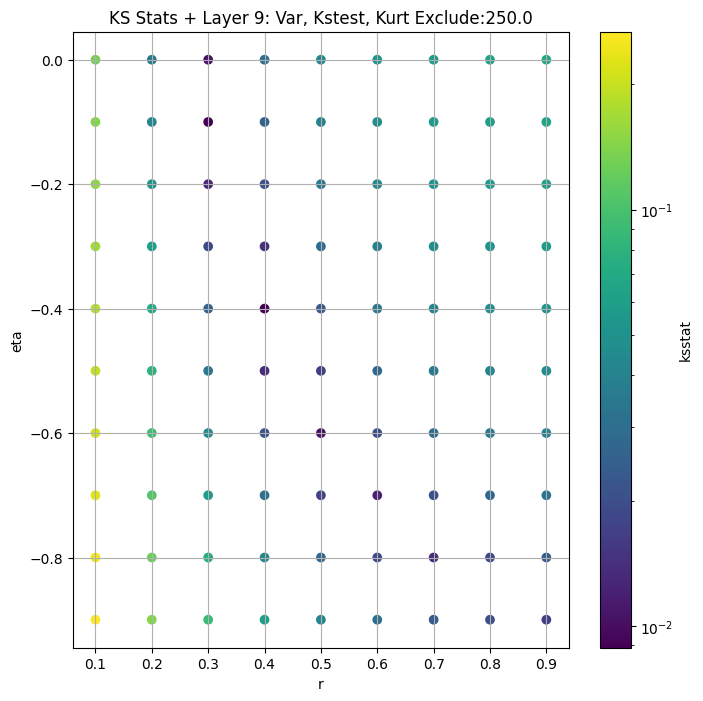

obs_var    var_lower     var_upper    obs_kurt  kurt_lower  \
layer                                                                   
2      9329.193000  8680.039000  10021.551000    5.728336    3.854069   
3      1371.856000  1239.007400   1522.100800   14.135717    9.524071   
4       585.124450   532.130500    642.267700   11.181561    8.105103   
5       160.717680   146.666210    175.814360   10.452751    7.672978   
6        38.403484    34.960827     42.293262   11.680919    7.695513   
7         8.761599     7.796952      9.977344   20.842588   11.143603   
8         1.901044     1.622445      2.434048   60.534340   15.293455   
9         0.338892     0.277782      0.548111  236.055190   12.296153   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        8.267125        13604.0             0.010589        2.7         -1.0   
3       23.448200        54416.0             0.221350        0.3         -1.3   
4       16.543982       166649.0             0.133170        0.3         -1.3   
5       15.774425       574769.0             0.074270        0.9         -1.3   
6       23.166769      2125625.0             0.009367        1.3         -1.2   
7       58.113117      8502500.0             0.008711        0.5         -1.1   
8      272.068180     34010000.0             0.006761        0.1          0.8   
9      879.158600    136040000.0             0.008880        0.4         -0.4   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       2.902462e+04                     0.0         9329.193000   
3       3.096091e+02                     0.0         1371.856000   
4       1.320546e+02                     0.0          585.124450   
5       7.390986e+02                     0.0          160.717680   
6       1.413333e+02                    50.0           35.818290   
7       6.084443e+00                     0.0            8.761599   
8       8.120580e-15                     0.0            1.901044   
9       1.069756e-02                   250.0            0.234200   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.011632  
3                     0.005819  
4                     0.003326  
5                     0.001791  
6                     0.000931  
7                     0.000466  
8                     0.000233  
9                     0.000116

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/167 [00:00<?, ?it/s]

Finding Minimum after computing 167 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.015207258911845822, var: 7013.111328125


  0%|          | 0/167 [00:00<?, ?it/s]

Finding Minimum after computing 167 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.013703736418320456, var: 7348.27392578125


  0%|          | 0/167 [00:00<?, ?it/s]

Finding Minimum after computing 167 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.012839296153877022, var: 7760.76171875


  0%|          | 0/167 [00:00<?, ?it/s]

Finding Minimum after computing 167 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.012081828495847324, var: 8300.2568359375


  0%|          | 0/167 [00:00<?, ?it/s]

Finding Minimum after computing 167 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.010589276548112536, var: 9329.193359375
Number of samples: 13604, Without approximation : 13604.0


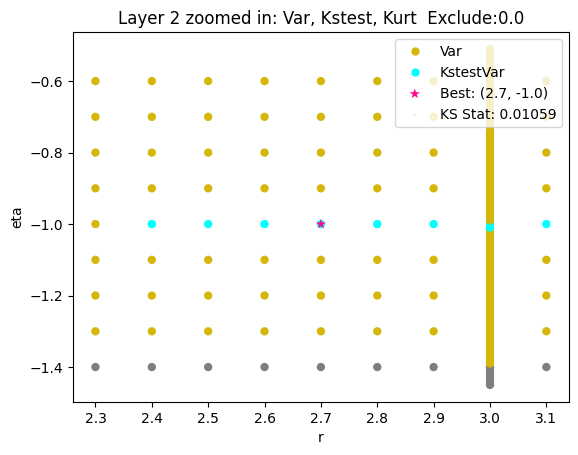

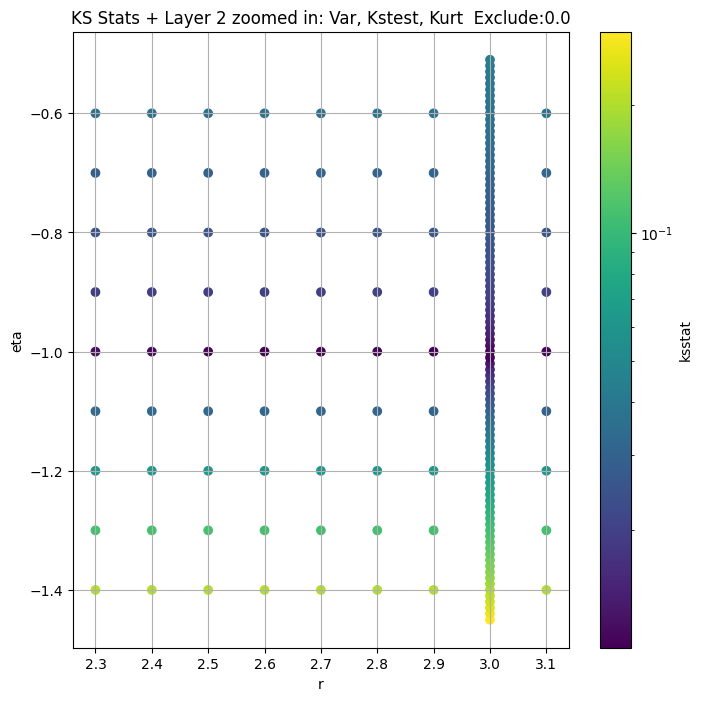

Layer 3


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.22135033813584215, var: 1143.261474609375


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.22135033813584215, var: 1179.3731689453125


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.22135033813584215, var: 1221.9263916015625


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.22135033813584215, var: 1274.82763671875


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.22135033813584215, var: 1371.85595703125
Number of samples: 54416, Without approximation : 54416.0


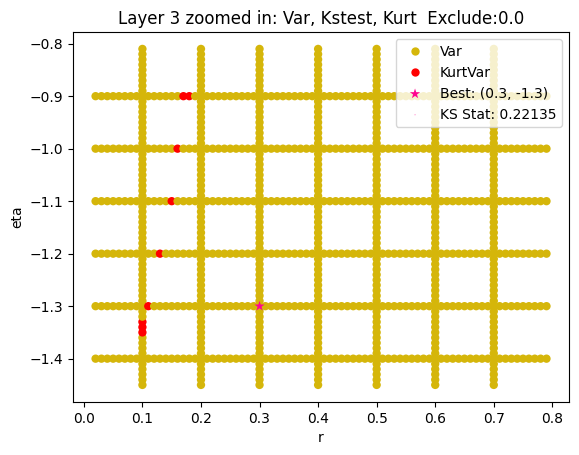

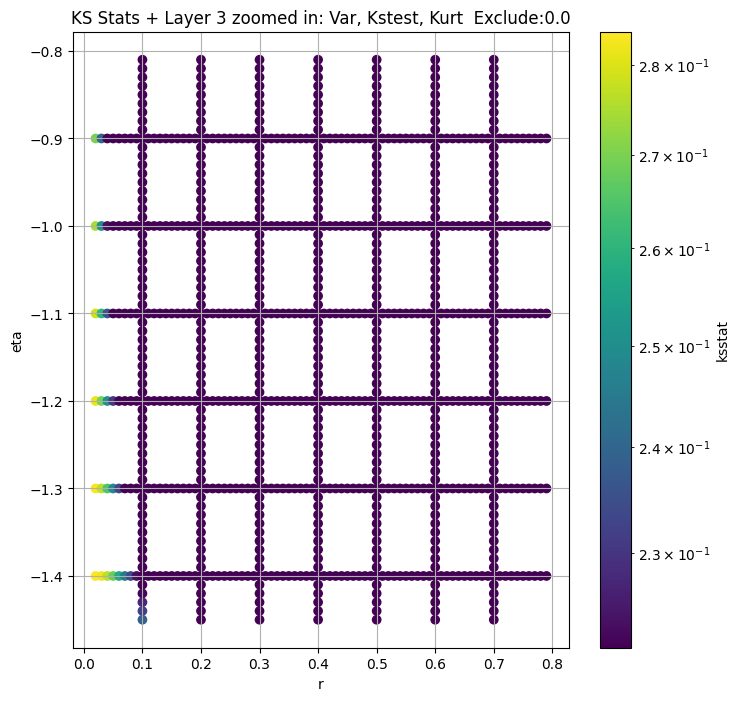

Layer 4


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 4, 0.0 + 100 = 100, ksstat: 0.1331699999999998, var: 525.7831420898438


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 4, 0.0 + 75 = 75, ksstat: 0.1331699999999998, var: 536.1165161132812


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 4, 0.0 + 50 = 50, ksstat: 0.1331699999999998, var: 547.9266357421875


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 4, 0.0 + 25 = 25, ksstat: 0.1331699999999998, var: 562.1409301757812


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 4, 0.0 + 0 = 0, ksstat: 0.1331699999999998, var: 585.1244506835938
Number of samples: 100000, Without approximation : 166649.0


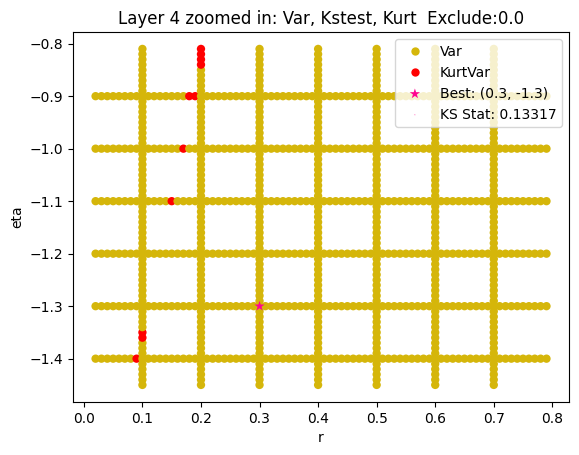

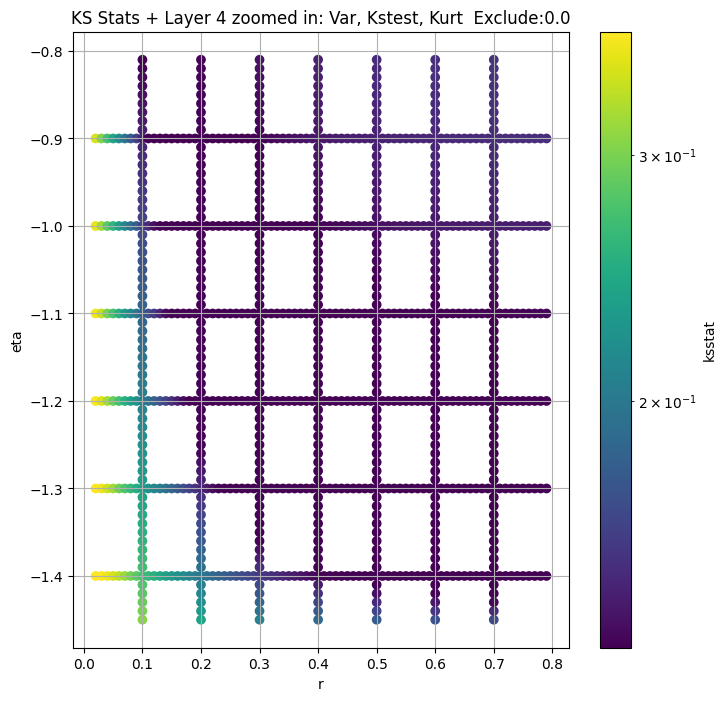

Layer 5


  0%|          | 0/1190 [00:00<?, ?it/s]

Finding Minimum after computing 1190 CDFs
layer 5, 0.0 + 100 = 100, ksstat: 0.07426999999999978, var: 145.08392333984375


  0%|          | 0/1190 [00:00<?, ?it/s]

Finding Minimum after computing 1190 CDFs
layer 5, 0.0 + 75 = 75, ksstat: 0.07426999999999978, var: 147.79730224609375


  0%|          | 0/1190 [00:00<?, ?it/s]

Finding Minimum after computing 1190 CDFs
layer 5, 0.0 + 50 = 50, ksstat: 0.07426999999999978, var: 150.8887176513672


  0%|          | 0/1190 [00:00<?, ?it/s]

Finding Minimum after computing 1190 CDFs
layer 5, 0.0 + 25 = 25, ksstat: 0.07426999999999978, var: 154.66119384765625


  0%|          | 0/1190 [00:00<?, ?it/s]

Finding Minimum after computing 1190 CDFs
layer 5, 0.0 + 0 = 0, ksstat: 0.07426999999999978, var: 160.71768188476562
Number of samples: 100000, Without approximation : 574769.0


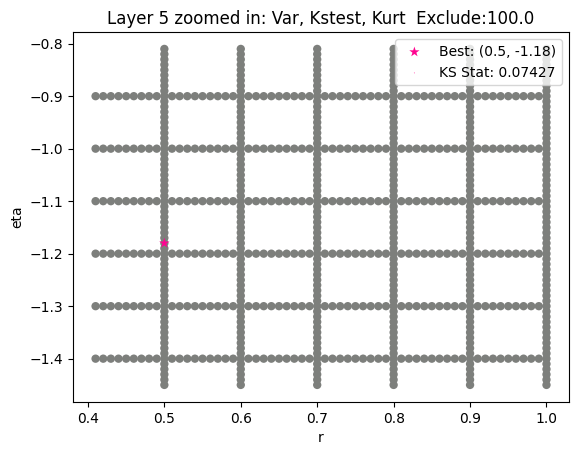

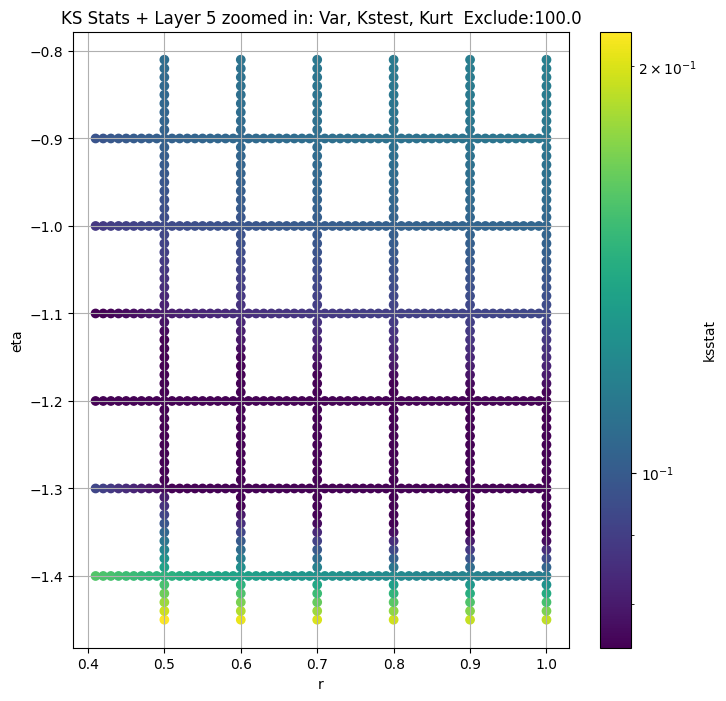

Layer 6


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 6, 50.0 + 100 = 150, ksstat: 0.009287980210739843, var: 33.255577087402344


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 6, 50.0 + 75 = 125, ksstat: 0.00919098653036099, var: 33.79656982421875


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 6, 50.0 + 50 = 100, ksstat: 0.00909454142854349, var: 34.38943862915039


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 6, 50.0 + 25 = 75, ksstat: 0.008988414474091044, var: 35.05204391479492


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 6, 50.0 + 0 = 50, ksstat: 0.00886779123275705, var: 35.81829071044922


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 6, 50.0 + -25 = 25, ksstat: 0.008877631704982791, var: 36.766361236572266


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 6, 50.0 + -50 = 0, ksstat: 0.008920379704413617, var: 38.40348434448242
Number of samples: 100000, Without approximation : 2125625.0


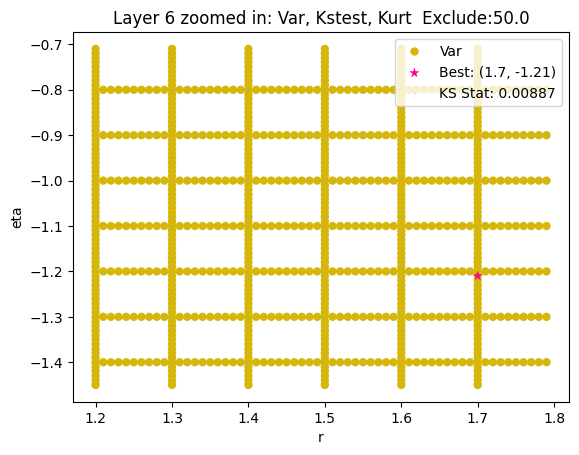

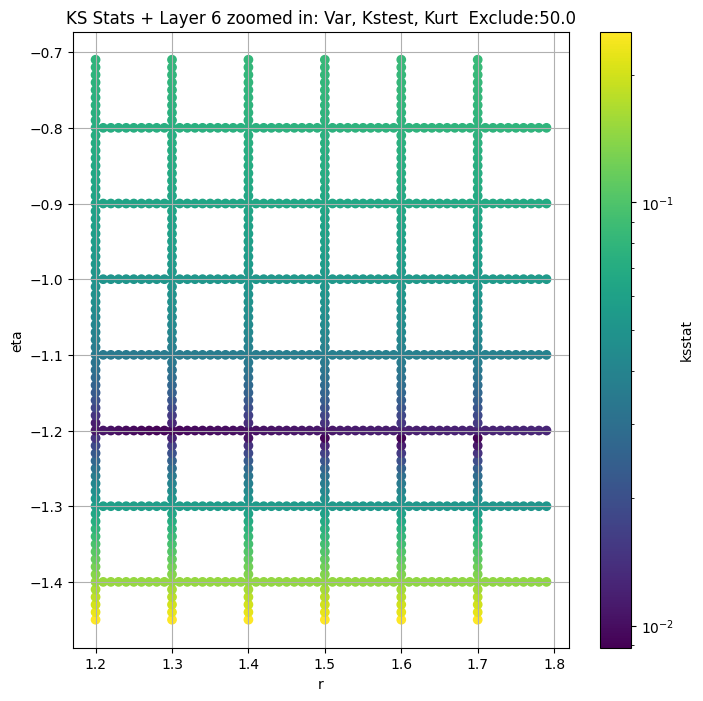

Layer 7


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 7, 0.0 + 100 = 100, ksstat: 0.008479247143282465, var: 7.549894332885742


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 7, 0.0 + 75 = 75, ksstat: 0.00831314728839605, var: 7.7362189292907715


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 7, 0.0 + 50 = 50, ksstat: 0.008418552158590331, var: 7.955531120300293


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 7, 0.0 + 25 = 25, ksstat: 0.008257580818905152, var: 8.23187255859375


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 7, 0.0 + 0 = 0, ksstat: 0.008710572469237232, var: 8.761598587036133
Number of samples: 100000, Without approximation : 8502500.0


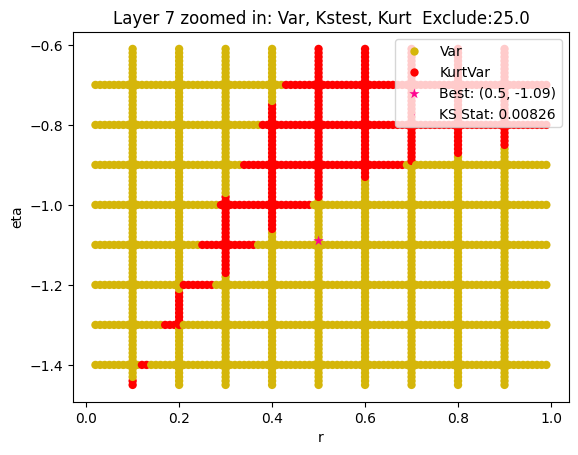

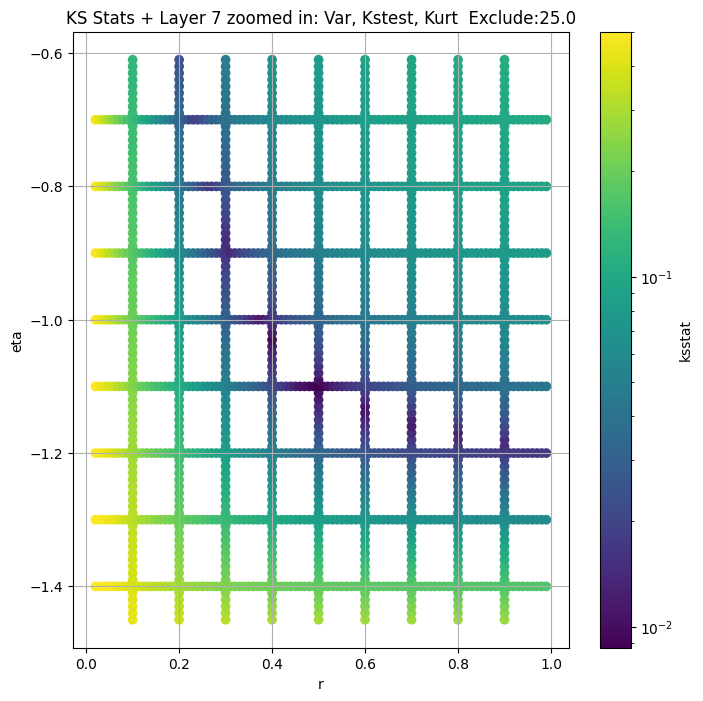

Layer 8


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 0.0 + 100 = 100, ksstat: 0.009867060106553638, var: 1.5349723100662231


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 0.0 + 75 = 75, ksstat: 0.010155078565850517, var: 1.5820682048797607


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 0.0 + 50 = 50, ksstat: 0.008476007716387235, var: 1.6391302347183228


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 0.0 + 25 = 25, ksstat: 0.008200983409707652, var: 1.7146220207214355


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 0.0 + 0 = 0, ksstat: 0.0067128649051499956, var: 1.901044249534607
Number of samples: 100000, Without approximation : 34010000.0


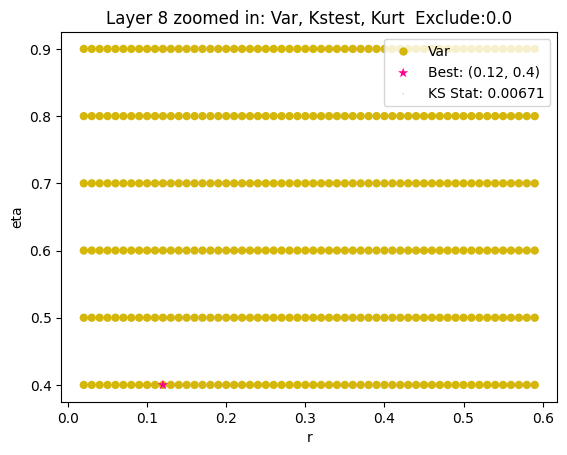

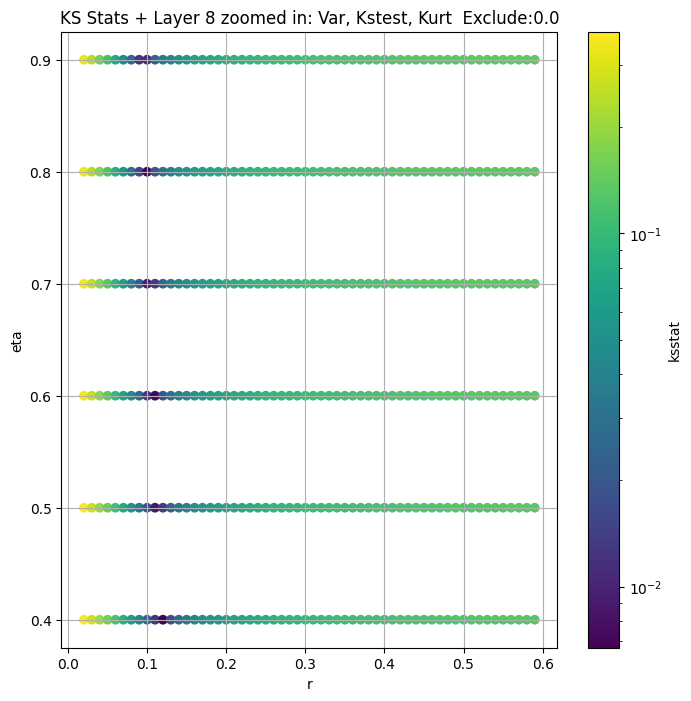

Layer 9


  0%|          | 0/1440 [00:00<?, ?it/s]

Finding Minimum after computing 1440 CDFs
layer 9, 250.0 + 100 = 350, ksstat: 0.00898059440857979, var: 0.22116084396839142


  0%|          | 0/1440 [00:00<?, ?it/s]

Finding Minimum after computing 1440 CDFs
layer 9, 250.0 + 75 = 325, ksstat: 0.008793589929436518, var: 0.2241559773683548


  0%|          | 0/1440 [00:00<?, ?it/s]

Finding Minimum after computing 1440 CDFs
layer 9, 250.0 + 50 = 300, ksstat: 0.008925494544979817, var: 0.2273121178150177


  0%|          | 0/1440 [00:00<?, ?it/s]

Finding Minimum after computing 1440 CDFs
layer 9, 250.0 + 25 = 275, ksstat: 0.008903072310624038, var: 0.2306516170501709


  0%|          | 0/1440 [00:00<?, ?it/s]

Finding Minimum after computing 1440 CDFs
layer 9, 250.0 + 0 = 250, ksstat: 0.008879746666895005, var: 0.2342004030942917


  0%|          | 0/1440 [00:00<?, ?it/s]

Finding Minimum after computing 1440 CDFs
layer 9, 250.0 + -25 = 225, ksstat: 0.008859165881722864, var: 0.23799245059490204


  0%|          | 0/1440 [00:00<?, ?it/s]

Finding Minimum after computing 1440 CDFs
layer 9, 250.0 + -50 = 200, ksstat: 0.008844412739488994, var: 0.24207192659378052


  0%|          | 0/1440 [00:00<?, ?it/s]

Finding Minimum after computing 1440 CDFs
layer 9, 250.0 + -75 = 175, ksstat: 0.009055269543873312, var: 0.24649406969547272


  0%|          | 0/1440 [00:00<?, ?it/s]

Finding Minimum after computing 1440 CDFs
layer 9, 250.0 + -100 = 150, ksstat: 0.008982315945319619, var: 0.2513413727283478
Number of samples: 100000, Without approximation : 136040000.0


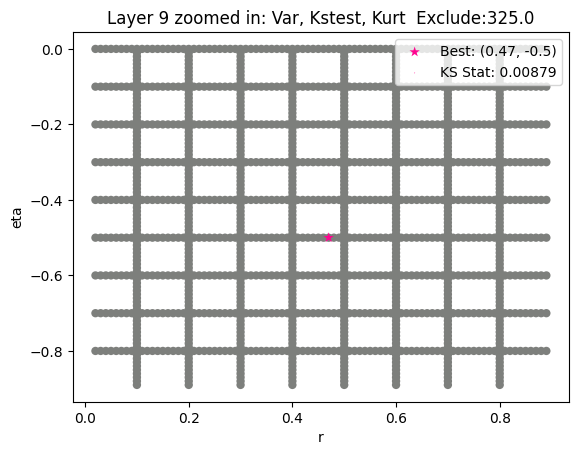

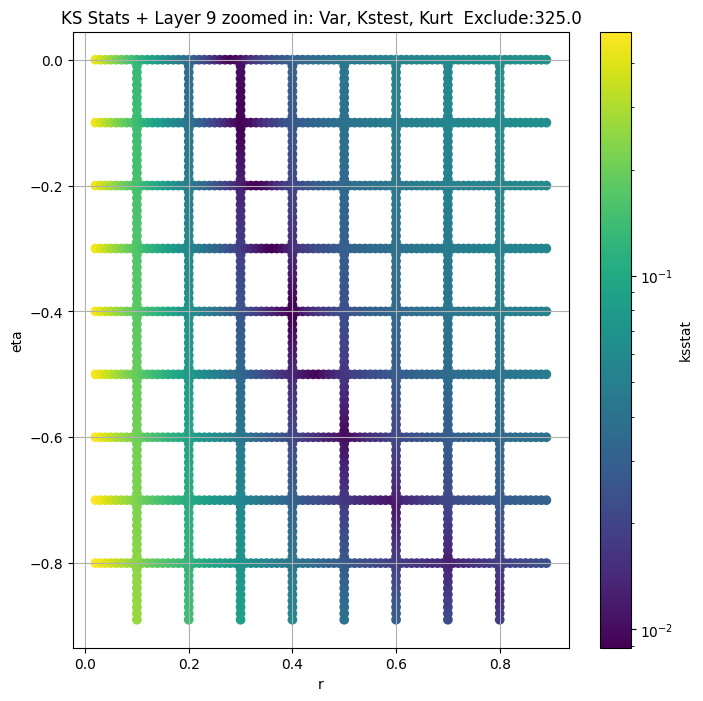

Not a fit


obs_var    var_lower     var_upper    obs_kurt  kurt_lower  \
layer                                                                   
2      9329.193000  8680.039000  10021.551000    5.728336    3.854069   
3      1371.856000  1239.007400   1522.100800   14.135717    9.524071   
4       585.124450   532.130500    642.267700   11.181561    8.105103   
5       160.717680   146.666210    175.814360   10.452751    7.672978   
6        38.403484    34.960827     42.293262   11.680919    7.695513   
7         8.761599     7.796952      9.977344   20.842588   11.143603   
8         1.901044     1.622445      2.434048   60.534340   15.293455   
9         0.338892     0.277782      0.548111  236.055190   12.296153   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        8.267125        13604.0             0.010589        2.7         -1.0   
3       23.448200        54416.0             0.221350        0.3         -1.3   
4       16.543982       166649.0             0.133170        0.3         -1.3   
5       15.774425       574769.0             0.074270        0.9         -1.3   
6       23.166769      2125625.0             0.009367        1.3         -1.2   
7       58.113117      8502500.0             0.008711        0.5         -1.1   
8      272.068180     34010000.0             0.006761        0.1          0.8   
9      879.158600    136040000.0             0.008880        0.4         -0.4   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       2.902462e+04                     0.0         9329.193000   
3       3.096091e+02                     0.0         1371.856000   
4       1.320546e+02                     0.0          585.124450   
5       7.390986e+02                     0.0          145.083923   
6       1.413333e+02                    50.0           35.818291   
7       6.084443e+00                     0.0            8.231873   
8       8.120580e-15                     0.0            1.901044   
9       1.069756e-02                   250.0            0.224156   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.011632          0.010589    2.70     -1.00   
3                     0.005819          0.221350    0.30     -1.30   
4                     0.003326          0.133170    0.30     -1.30   
5                     0.001791          0.074270    0.50     -1.18   
6                     0.000931          0.008868    1.70     -1.21   
7                     0.000466          0.008258    0.50     -1.09   
8                     0.000233          0.006713    0.12      0.40   
9                     0.000116          0.008794    0.47     -0.50   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      2.902462e+04                  0.0        17217  
3      3.096091e+02                  0.0           -1  
4      1.320546e+02                  0.0          100  
5      1.382278e+02                100.0          315  
6      1.602676e+02                 50.0        23641  
7      5.515862e+00                 25.0        28021  
8      3.599265e-11                  0.0        42033  
9      2.850068e-02                325.0        24909

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

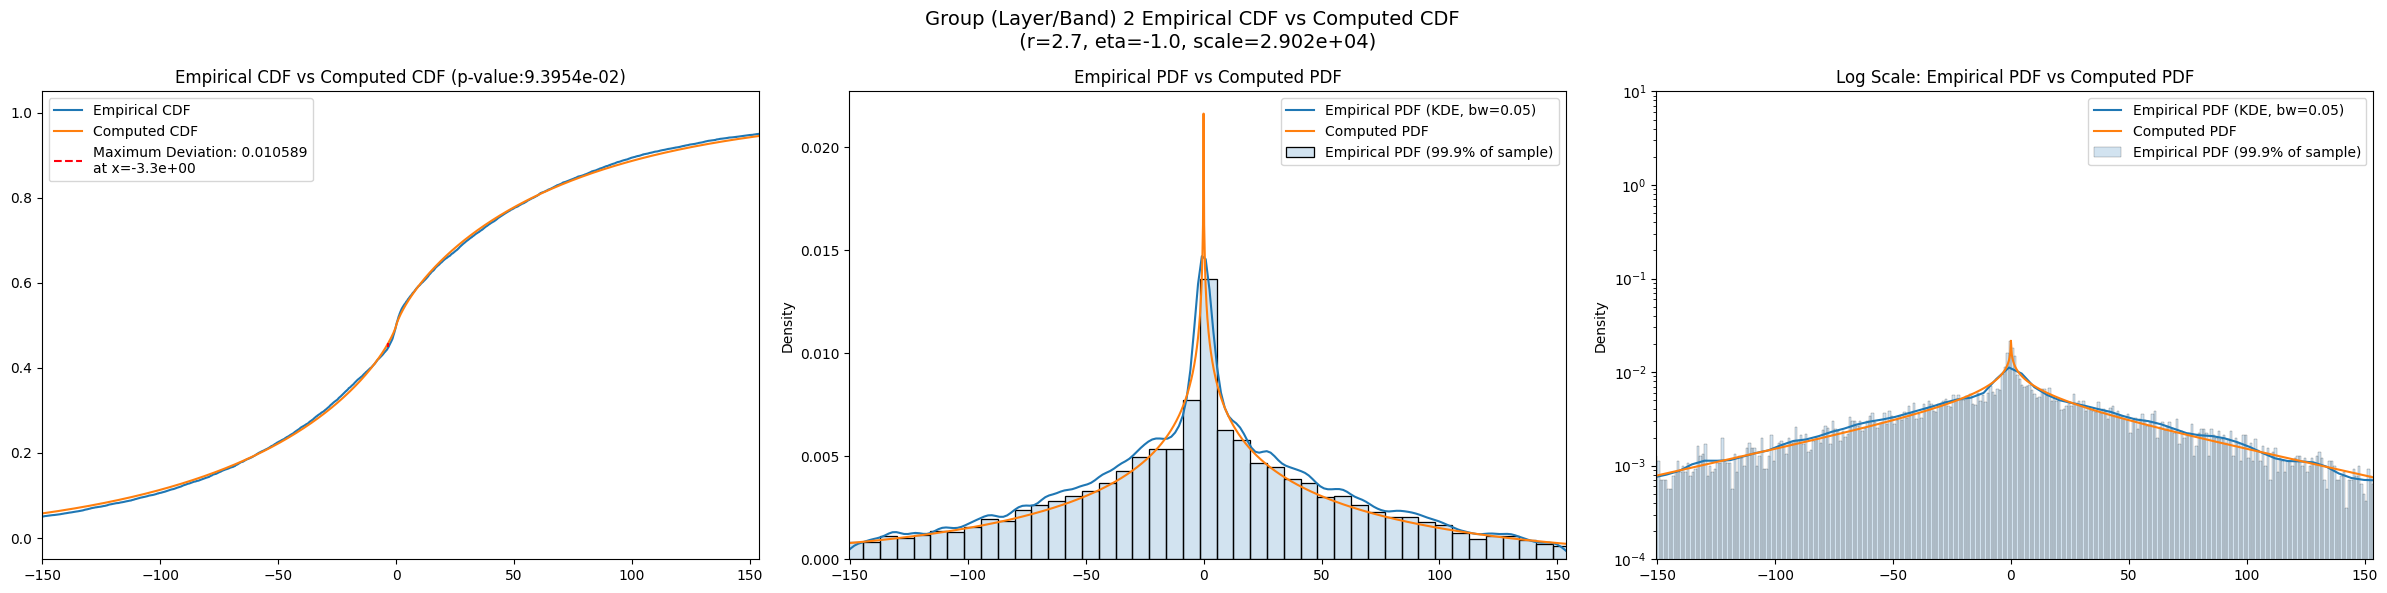

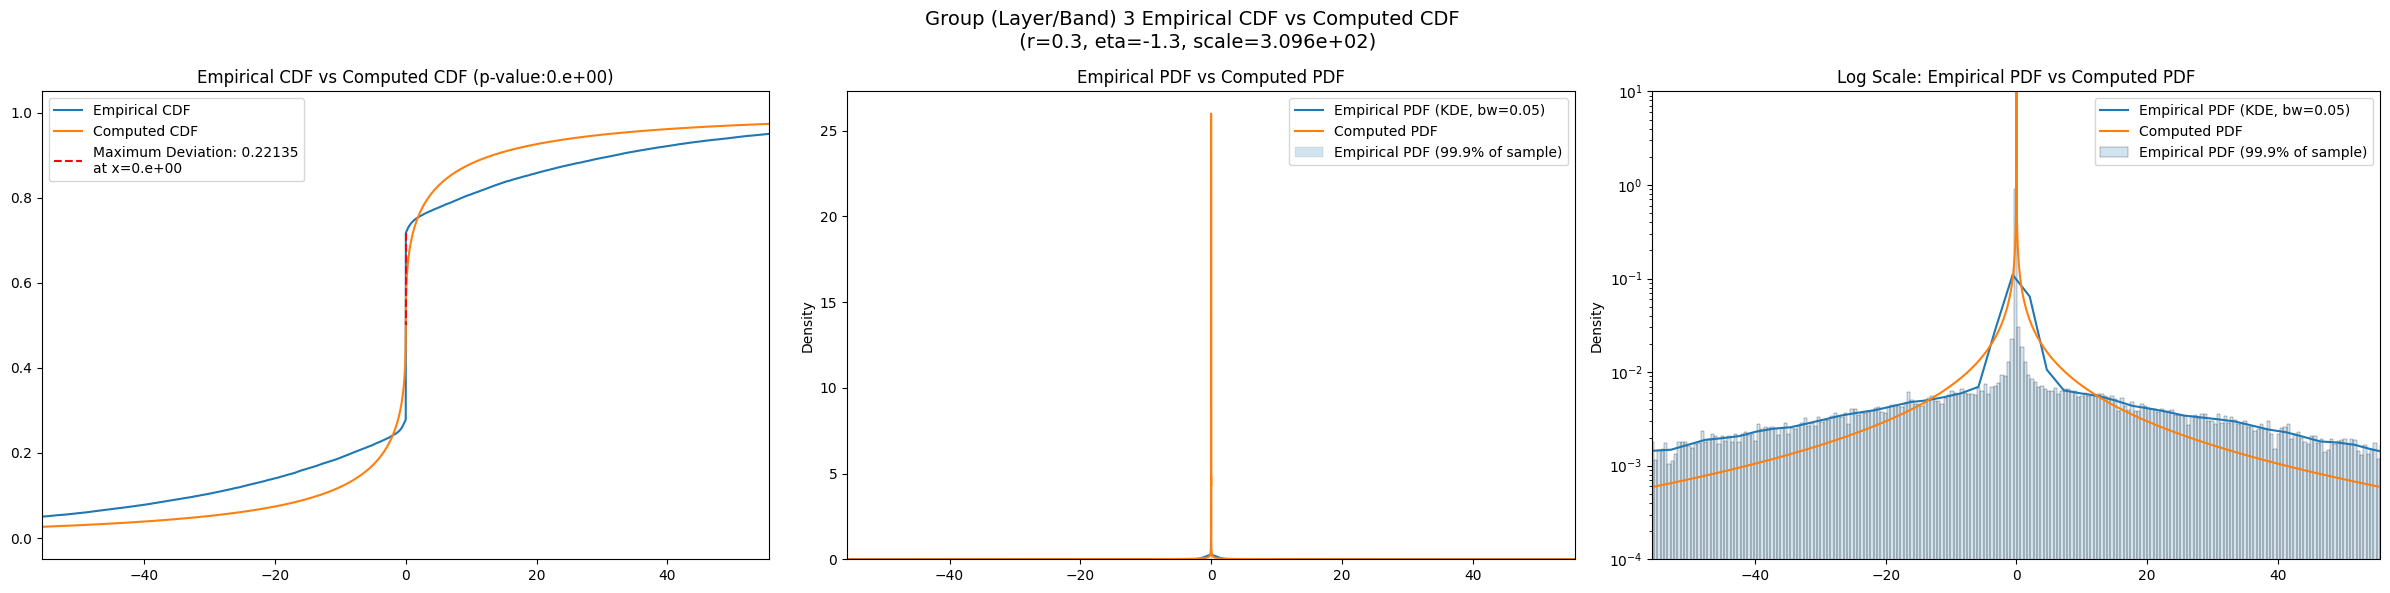

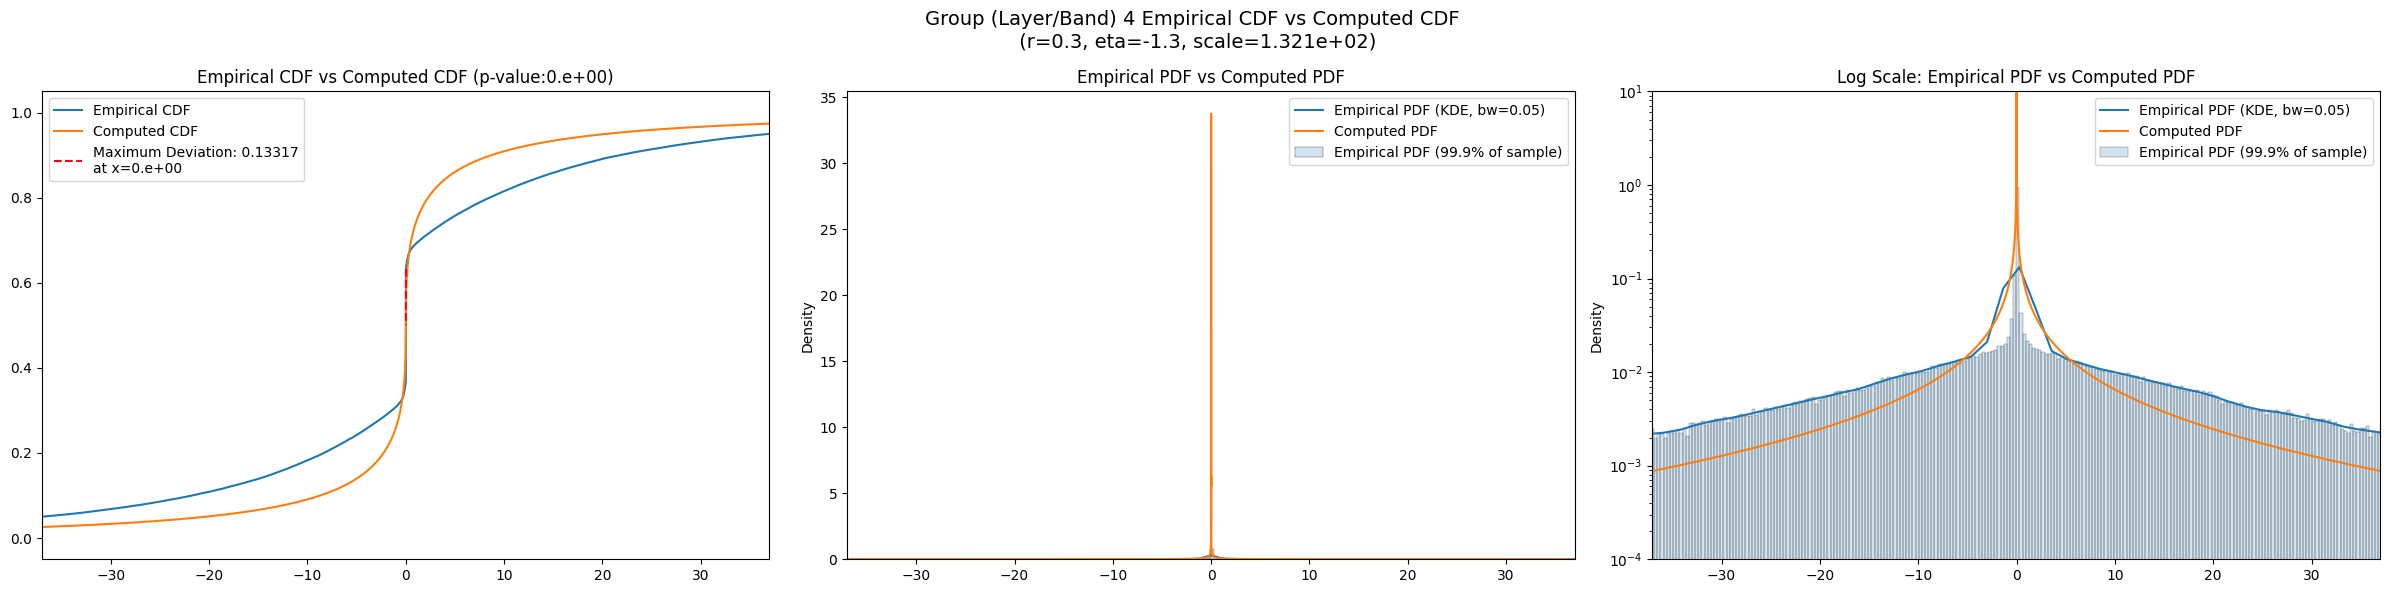

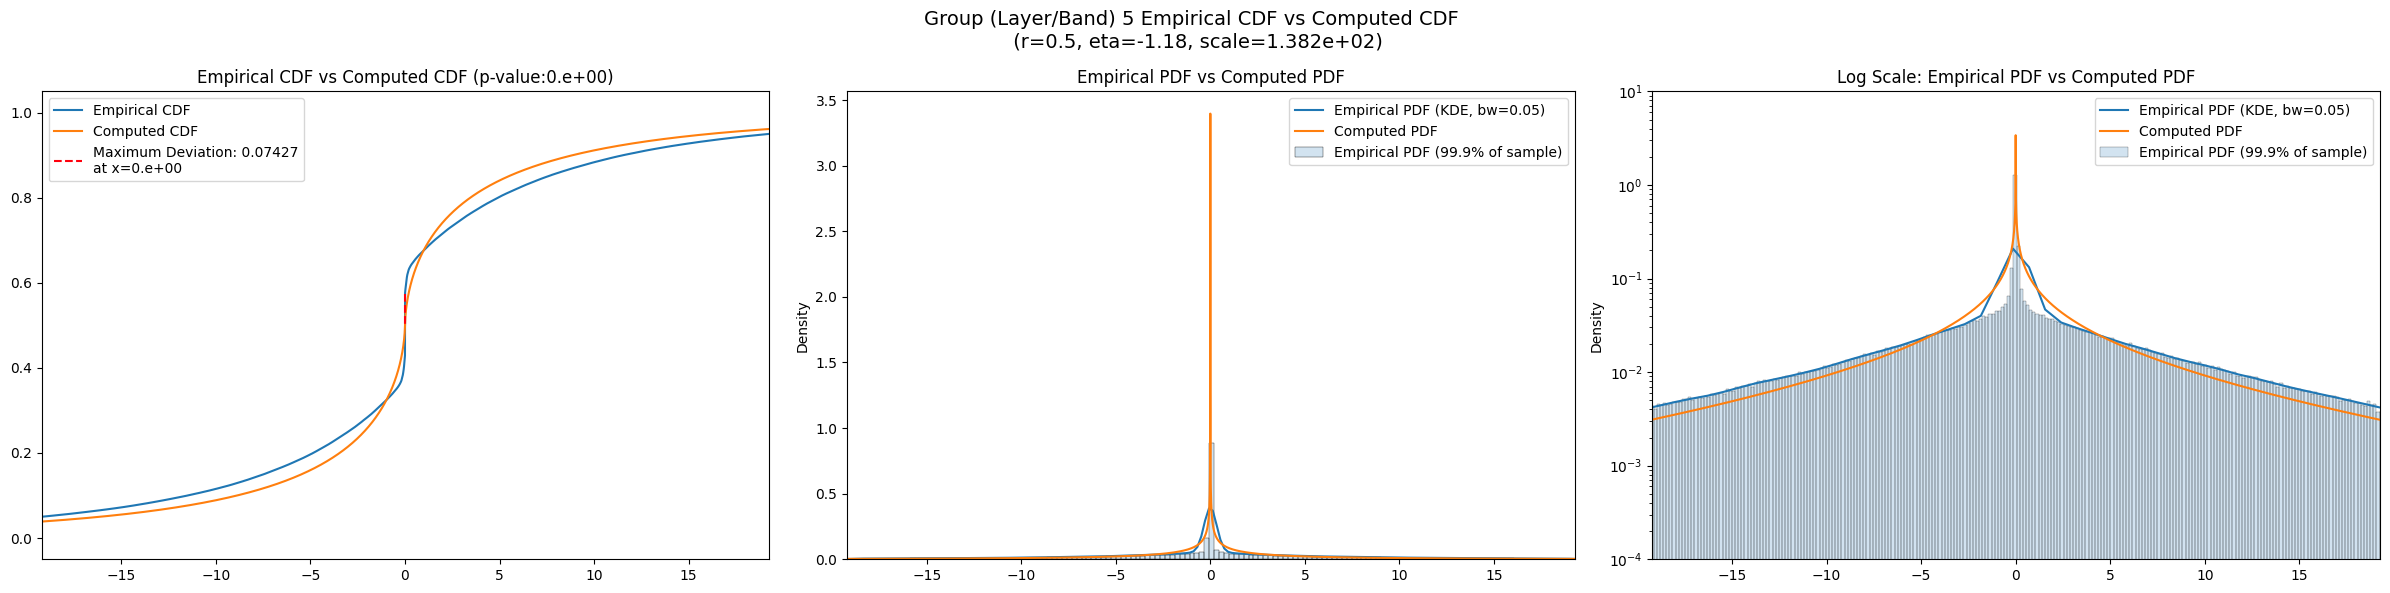

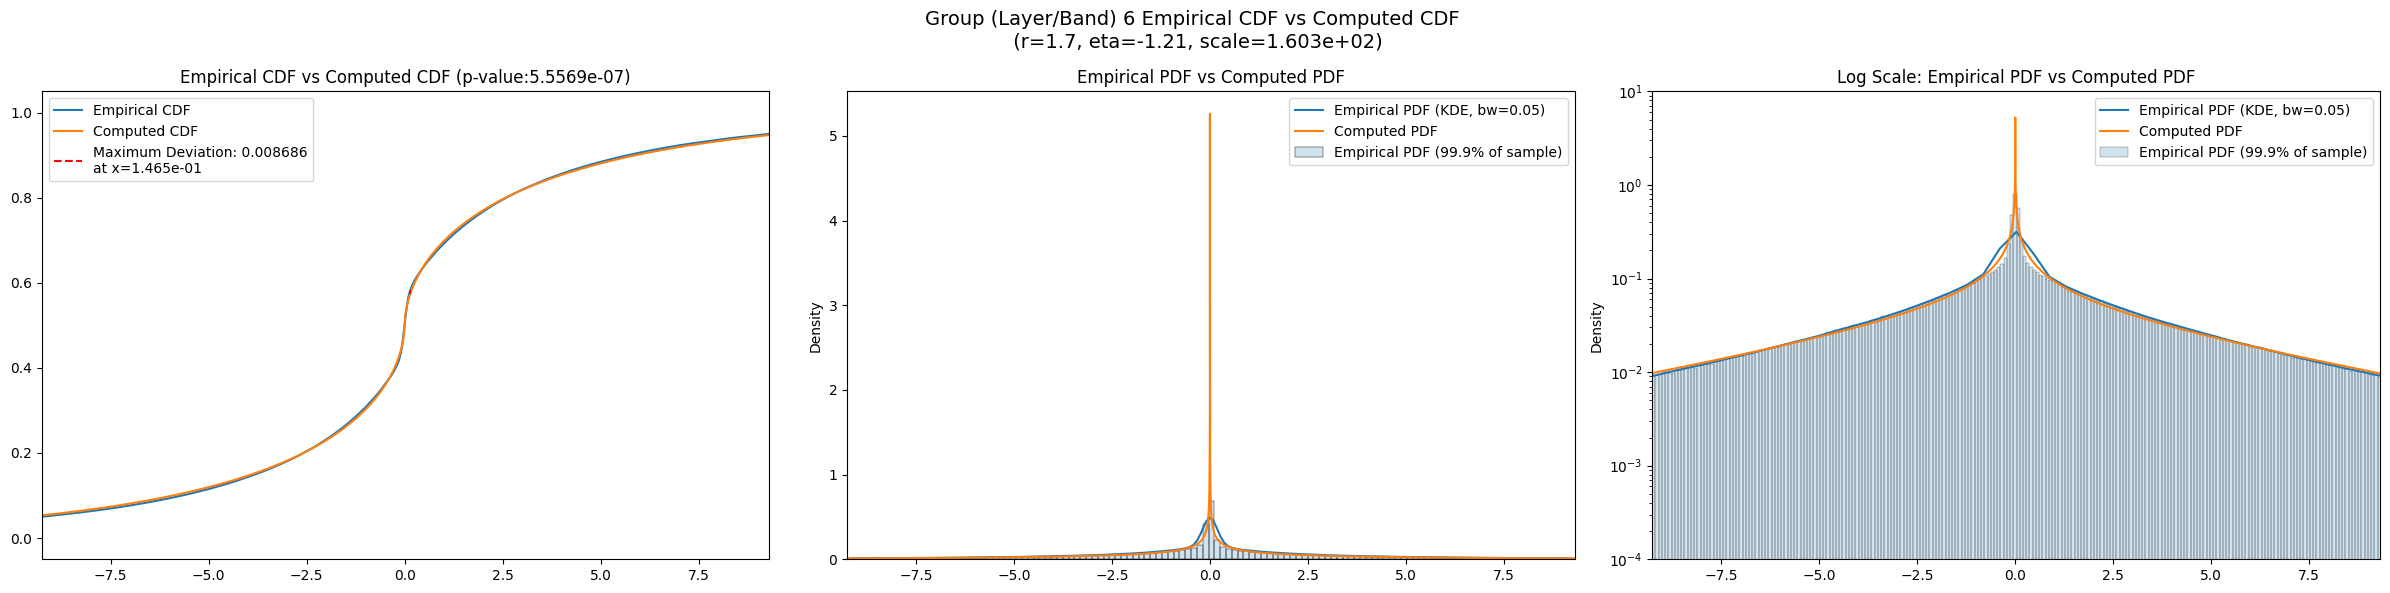

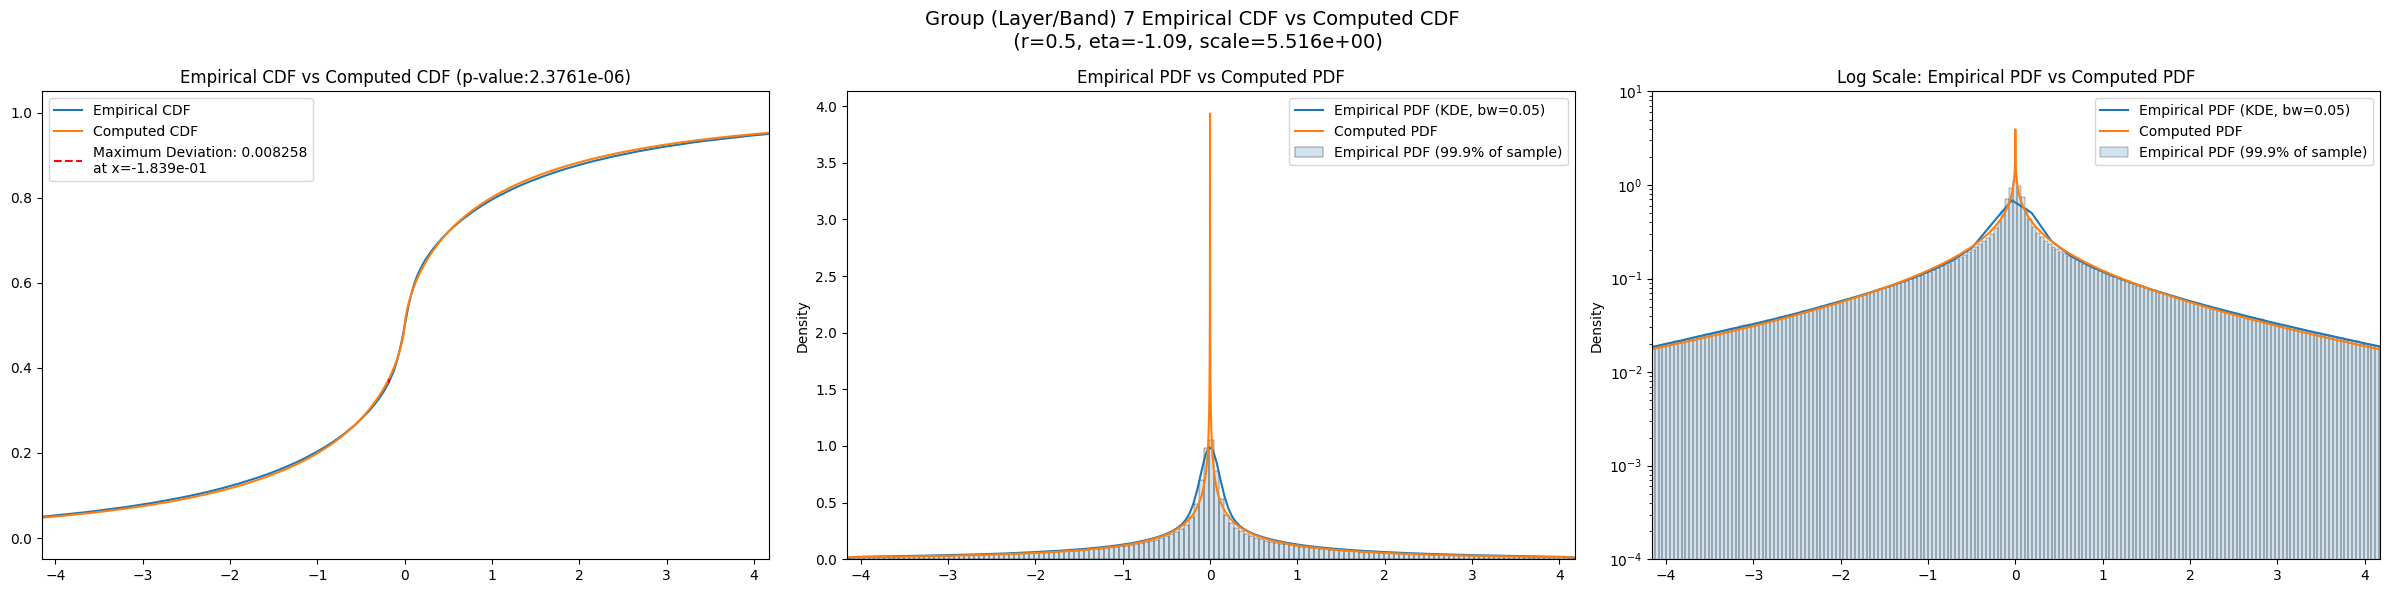

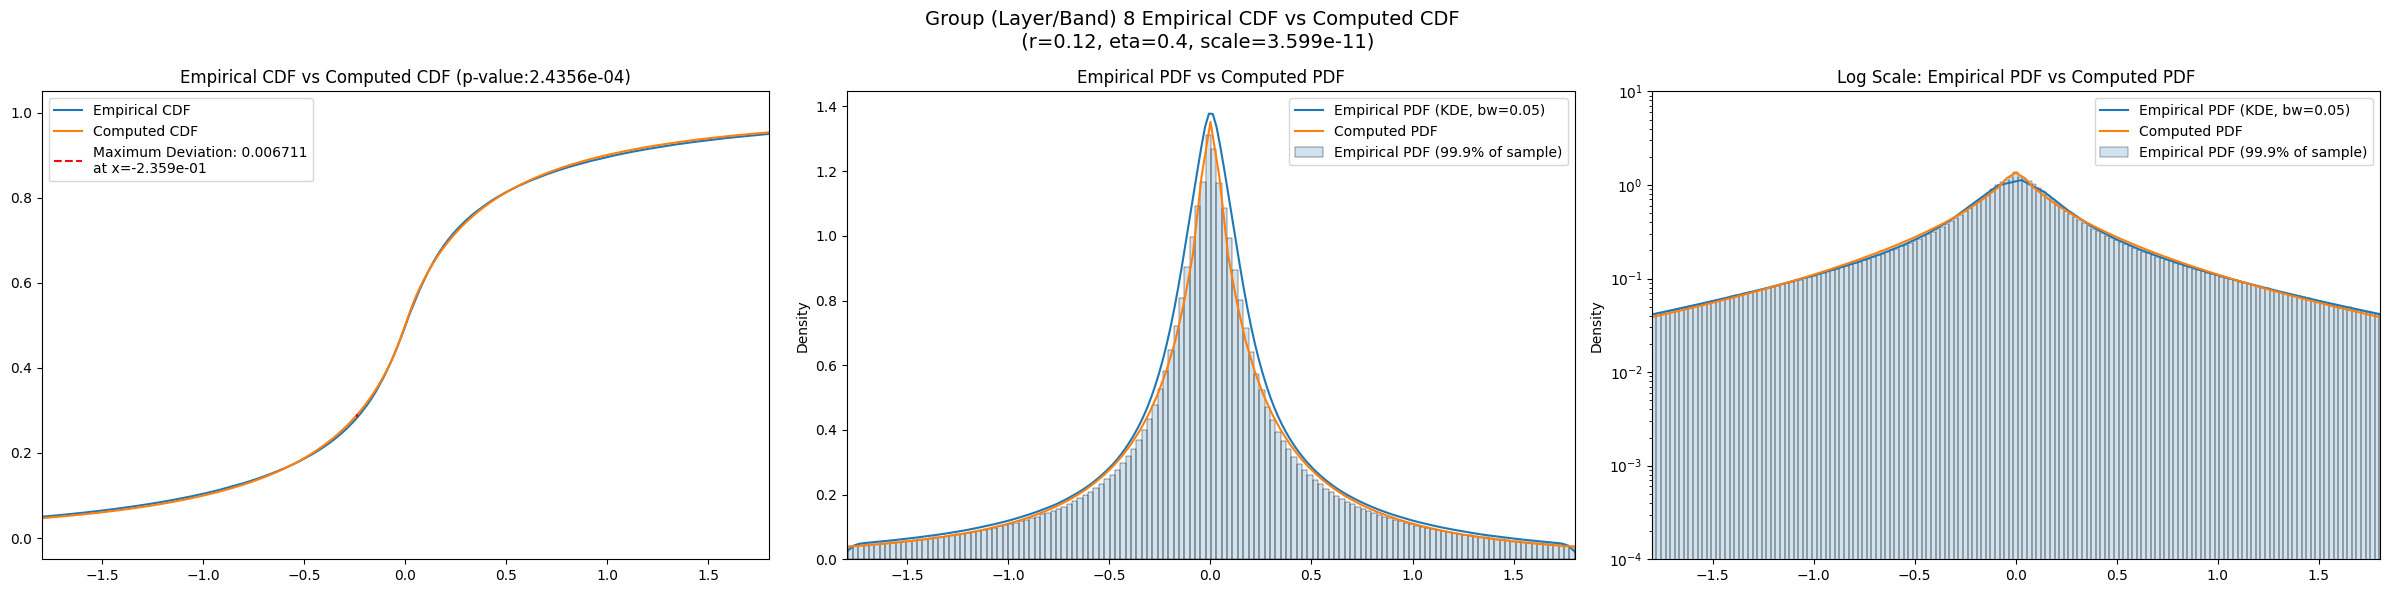

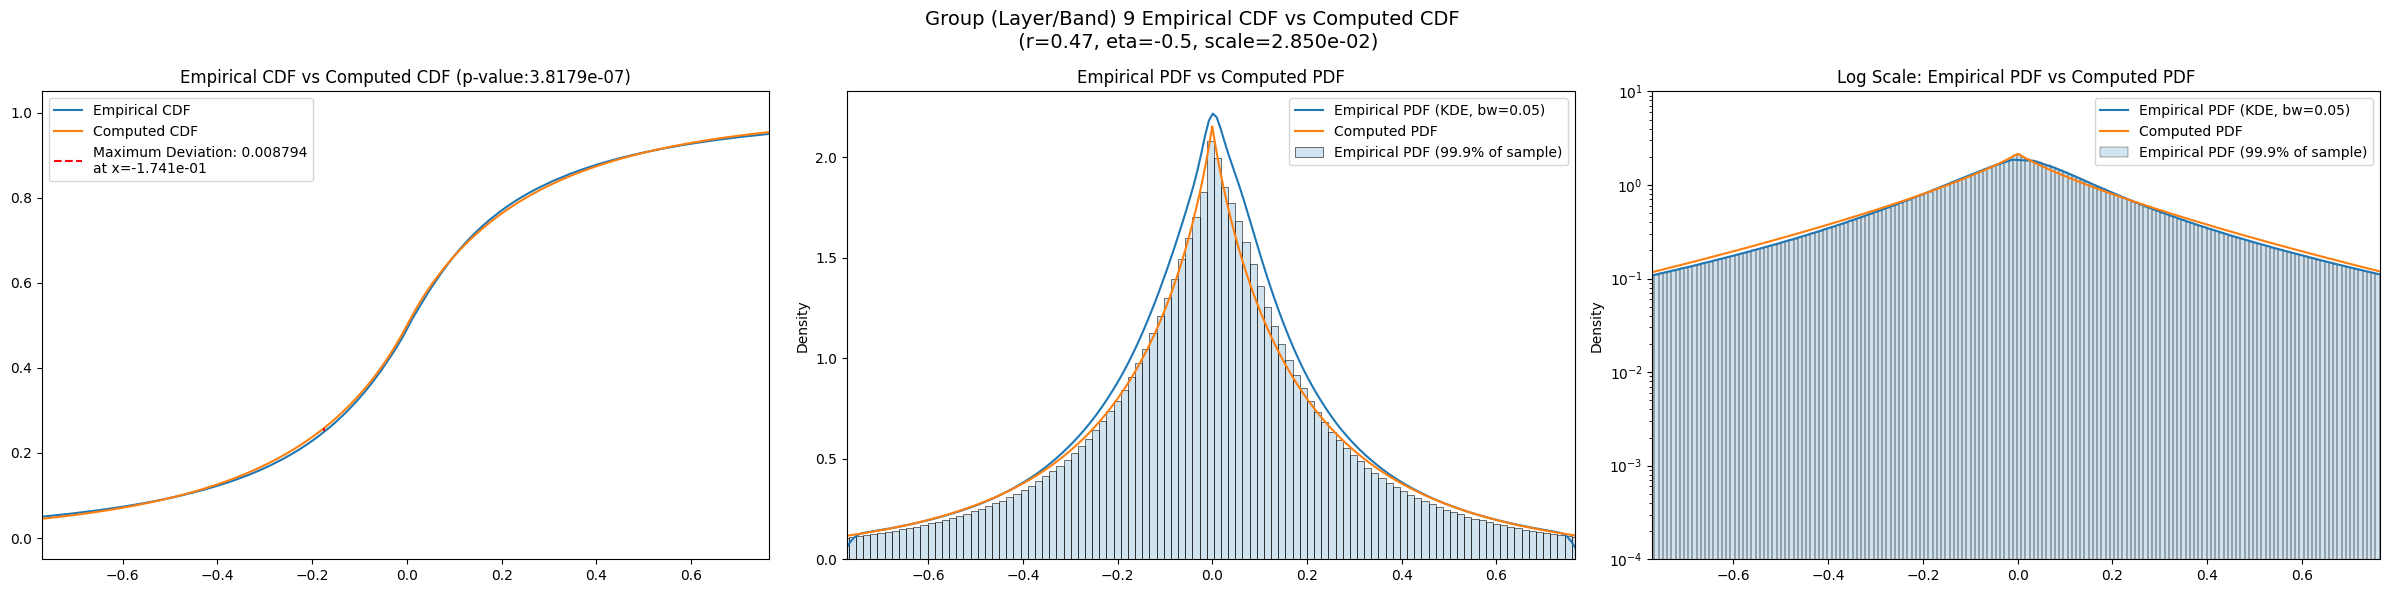

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var    var_lower     var_upper    obs_kurt  kurt_lower  \
layer                                                                   
2      9329.193000  8680.039000  10021.551000    5.728336    3.854069   
3      1371.856000  1239.007400   1522.100800   14.135717    9.524071   
4       585.124450   532.130500    642.267700   11.181561    8.105103   
5       160.717680   146.666210    175.814360   10.452751    7.672978   
6        38.403484    34.960827     42.293262   11.680919    7.695513   
7         8.761599     7.796952      9.977344   20.842588   11.143603   
8         1.901044     1.622445      2.434048   60.534340   15.293455   
9         0.338892     0.277782      0.548111  236.055190   12.296153   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        8.267125        13604.0             0.010589        2.7         -1.0   
3       23.448200        54416.0             0.221350        0.3         -1.3   
4       16.543982       166649.0             0.133170        0.3         -1.3   
5       15.774425       574769.0             0.074270        0.9         -1.3   
6       23.166769      2125625.0             0.009367        1.3         -1.2   
7       58.113117      8502500.0             0.008711        0.5         -1.1   
8      272.068180     34010000.0             0.006761        0.1          0.8   
9      879.158600    136040000.0             0.008880        0.4         -0.4   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...       69.287000              0.040294          1.252140e-19   
3      ...        2.438940              0.221350          0.000000e+00   
4      ...        5.727580              0.148298          0.000000e+00   
5      ...        4.281610              0.112812          0.000000e+00   
6      ...        2.973640              0.072917          0.000000e+00   
7      ...        1.225150              0.078034          0.000000e+00   
8      ...        0.597356              0.063784          0.000000e+00   
9      ...        0.314981              0.046406          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          56.830700             0.024079         2.768740e-07  47.792600   
3           3.503730             0.221350         0.000000e+00   2.276850   
4           4.242180             0.138181         0.000000e+00   3.284000   
5           3.242220             0.101703         0.000000e+00   2.600260   
6           2.380000             0.055144         0.000000e+00   1.910720   
7           1.035980             0.053863         0.000000e+00   0.816269   
8           0.525008             0.036634         0.000000e+00   0.415270   
9           0.277788             0.019416         0.000000e+00   0.218897   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.028424   5.549410e-10          9.395391e-02  
3           0.221350   0.000000e+00          0.000000e+00  
4           0.139636   0.000000e+00          0.000000e+00  
5           0.104148   0.000000e+00          0.000000e+00  
6           0.058661   0.000000e+00         1.288477e-145  
7           0.056533   0.000000e+00          0.000000e+00  
8           0.035998   0.000000e+00          0.000000e+00  
9           0.019679   0.000000e+00          0.000000e+00  

[8 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.010589                 0.011632          0.010589   
3                 0.221350                 0.005819          0.221350   
4                 0.133170                 0.003326          0.133170   
5                 0.074270                 0.001791          0.074270   
6                 0.009367                 0.000931          0.008868   
7                 0.008711                 0.000466          0.008258   
8                 0.006761                 0.000233          0.006713   
9                 0.008880                 0.000116          0.008794   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.040294             0.024079       0.028424  
3                  0.221350             0.221350       0.221350  
4                  0.148298             0.138181       0.139636  
5                  0.112812             0.101703       0.104148  
6                  0.072917             0.055144       0.058661  
7                  0.078034             0.053863       0.056533  
8                  0.063784             0.036634       0.035998  
9                  0.046406             0.019416       0.019679

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2             9329.193000          0.010589    2.70     -1.00  2.902462e+04   
3             1371.856000          0.221350    0.30     -1.30  3.096091e+02   
4              585.124450          0.133170    0.30     -1.30  1.320546e+02   
5              145.083923          0.074270    0.50     -1.18  1.382278e+02   
6               35.818291          0.008868    1.70     -1.21  1.602676e+02   
7                8.231873          0.008258    0.50     -1.09  5.515862e+00   
8                1.901044          0.006713    0.12      0.40  3.599265e-11   
9                0.224156          0.008794    0.47     -0.50  2.850068e-02   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                      0.0  
5                    100.0  
6                     50.0  
7                     25.0  
8                      0.0  
9                    325.0

In [21]:
eng.quit()